In [261]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import scipy.stats as spst
import matplotlib.cm as cm
import missingno as msno

# 한글 폰트 설정하기
fe = fm.FontEntry(fname = 'MaruBuri-Regular.otf', name = 'MaruBuri')
fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='Malgun Gothic')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [285]:
# train test data 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 데이터 탐색

In [10]:
display(train.head())
display(test.head())

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1
4,TEST_004,K사,EV6,Brand New,NaN,FWD,7597,10,No,0


In [4]:
# train/test data개수 파악
display(train.info())
print('*'*50)
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


None

**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        846 non-null    object 
 1   제조사       846 non-null    object 
 2   모델        846 non-null    object 
 3   차량상태      846 non-null    object 
 4   배터리용량     542 non-null    float64
 5   구동방식      846 non-null    object 
 6   주행거리(km)  846 non-null    int64  
 7   보증기간(년)   846 non-null    int64  
 8   사고이력      846 non-null    object 
 9   연식(년)     846 non-null    int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 66.2+ KB


None

<Axes: >

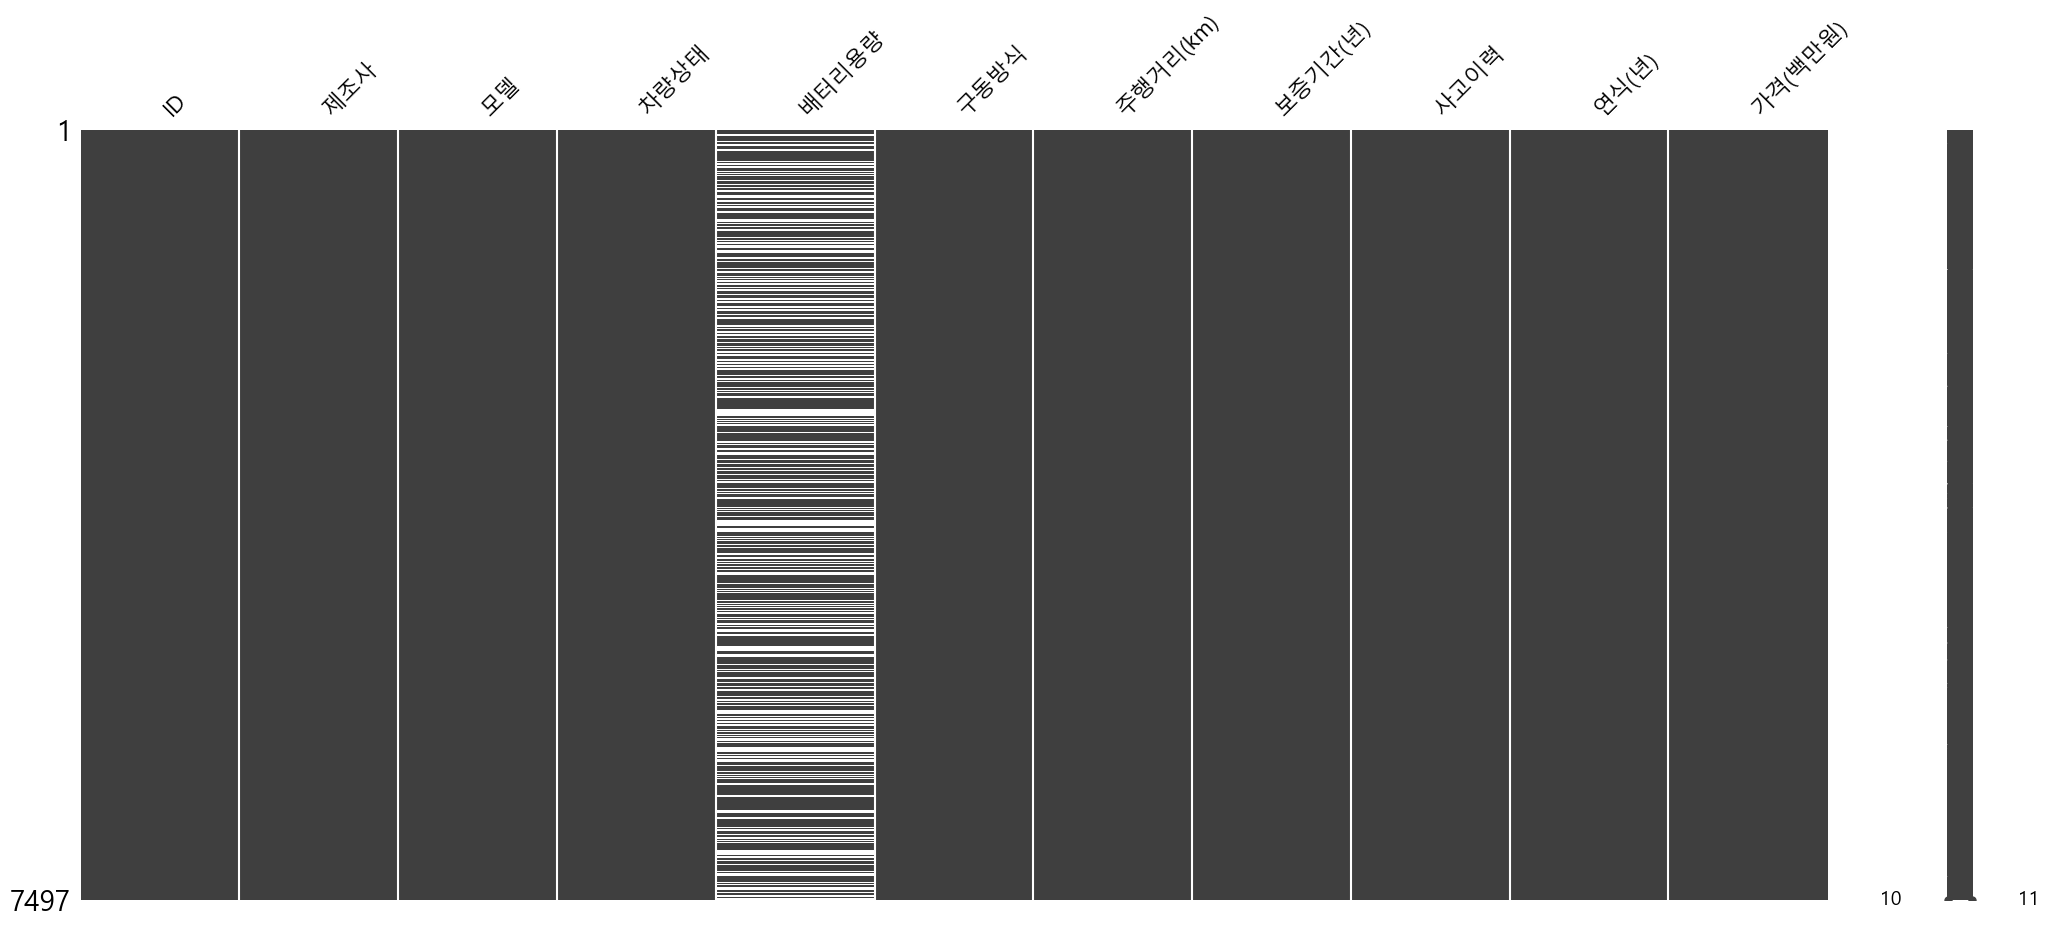

In [110]:
msno.matrix(train)

- 배터리용량 결측치 존재 ==> 어떻게 채울지?

In [9]:
# 통계값 확인
display(train.describe())
display(test.describe())

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
count,4786.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,69.397187,44287.979458,4.960918,0.222489,62.331949
std,15.283635,55204.064386,3.155342,0.569232,36.646759
min,46.000000,3.000000,0.000000,0.000000,9.000000
25%,56.359000,5465.000000,2.000000,0.000000,34.390000
50%,68.125000,17331.000000,5.000000,0.000000,56.000000
75%,78.227000,61252.000000,8.000000,0.000000,80.050000
max,99.800000,199827.000000,10.000000,2.000000,161.090000


,배터리용량,주행거리(km),보증기간(년),연식(년)
count,542.000000,846.000000,846.000000,846.000000
mean,69.712963,44664.152482,5.027187,0.206856
std,15.078398,55518.084064,3.157479,0.544798
min,46.000000,2.000000,0.000000,0.000000
25%,56.623000,6156.500000,2.000000,0.000000
50%,68.479000,17254.000000,5.000000,0.000000
75%,78.035250,60141.250000,8.000000,0.000000
max,99.800000,199948.000000,10.000000,2.000000


## 단변량 분석

### 1. 수치형 변수

In [124]:
def plot_num(data, columns_to_plot, cols=2, figsize=(10, 5)):
    # 해당 열이 데이터 내 존재하는 지 확인
    valid_columns = [col for col in columns_to_plot if col in data.columns]
    if not valid_columns:
        raise ValueError("해당 열이 존재하지 않습니다.")

    # 서브플롯을 생성하기 위해 행과 열의 수를 확인
    num_vars = len(valid_columns)
    rows = math.ceil(num_vars * 2 / cols)  # 히스토그램과 박스플롯이 한 열에 두 개씩 그려지므로 *2

    # 서브플롯을 생성
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(valid_columns):
        # 히스토그램
        sns.histplot(x=data[col], ax=axes[2 * i], kde=True)
        axes[2 * i].set_title(f"Histogram of {col}")

        # 박스플롯
        sns.boxplot(x=data[col], ax=axes[2 * i + 1])
        axes[2 * i + 1].set_title(f"Boxplot of {col}")

    # 빈 서브플롯을 삭제
    for j in range(2 * len(valid_columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

#### (1) 배터리용량

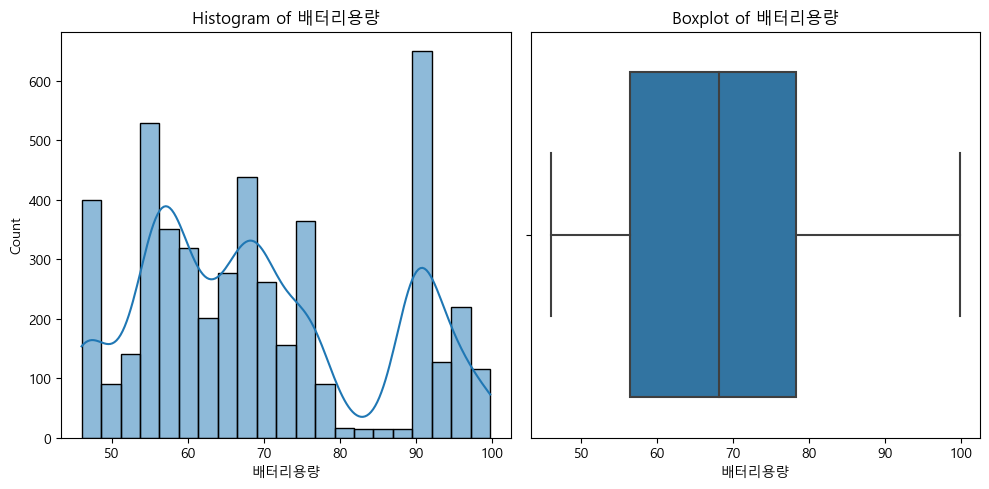

In [125]:
columns_to_plot = ['배터리용량']

# train 분포 확인
plot_num(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

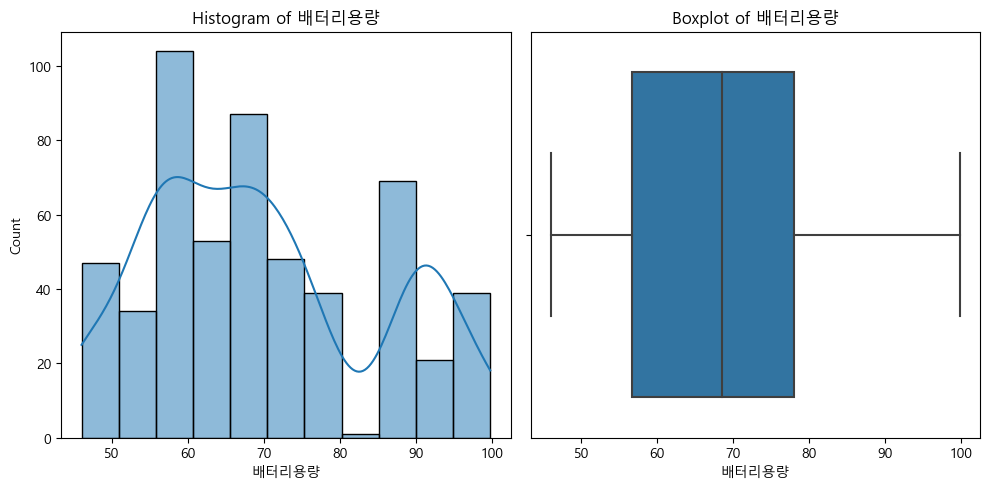

In [126]:
# test 분포 확인
plot_num(data=test, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

- 배터리 용량이 80~90사이의 값이 애초에 값이 없는 것일지, 아니면 원래 그 부분은 존재하지 않는지

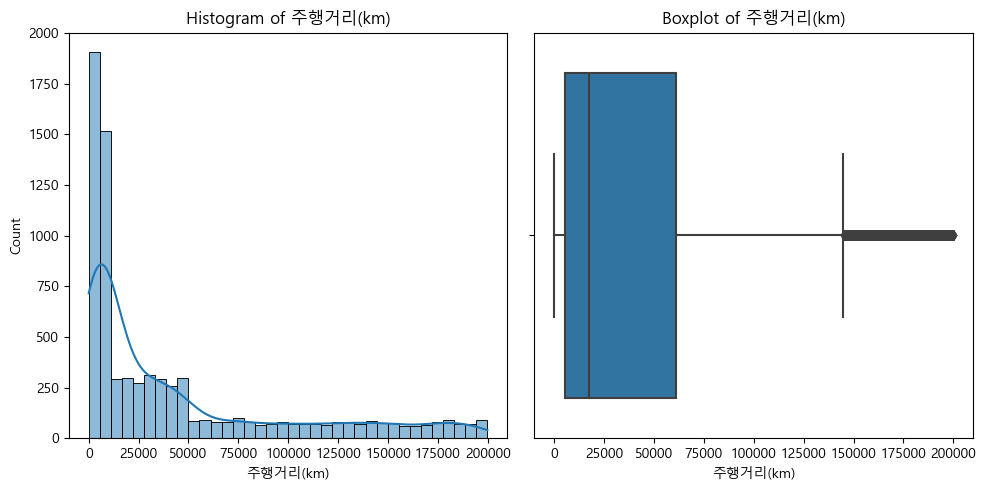

In [127]:
columns_to_plot = ['주행거리(km)']

# train 분포 확인
plot_num(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

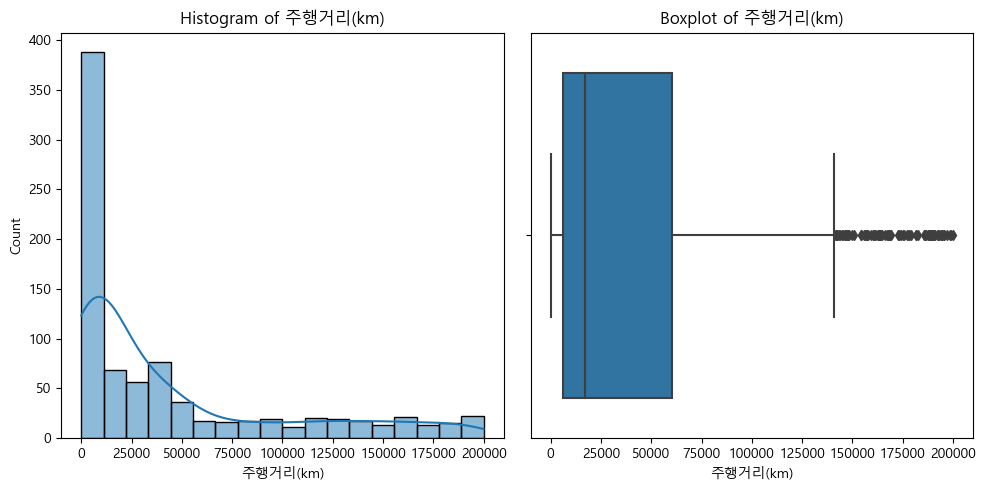

In [128]:
# test 분포 확인
plot_num(data=test, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

#### (3) 보증기간

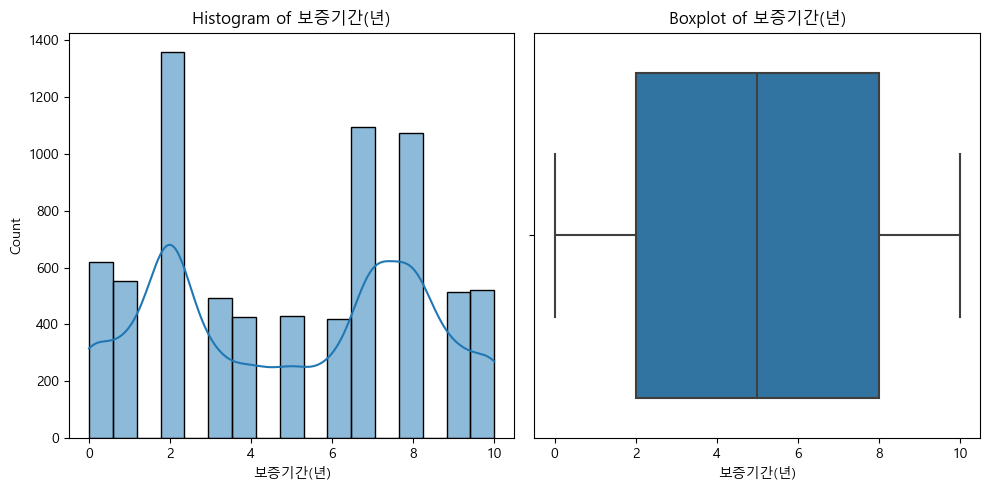

In [129]:
columns_to_plot = ['보증기간(년)']

# train 분포 확인
plot_num(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

- 보증기간을 3구간으로 나눠서 한 번 시도를 해보는 건...? 너무 중간중간 값들이 연결이 안되어있어서

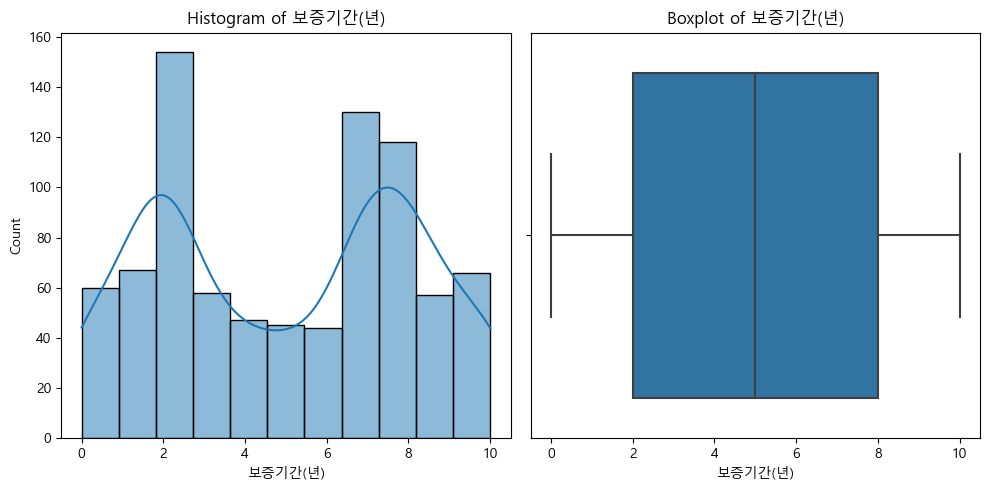

In [130]:
# test 분포 확인
plot_num(data=test, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

#### (4) 연식

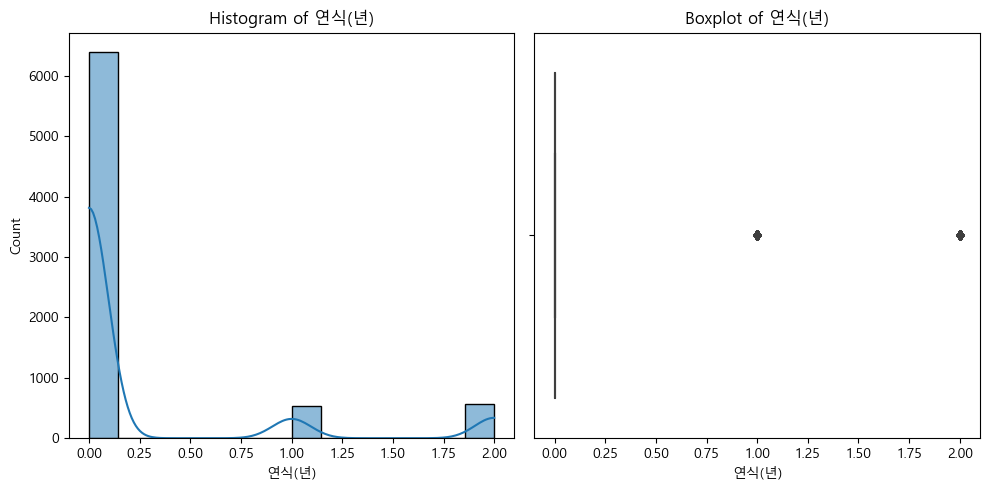

In [131]:
columns_to_plot = ['연식(년)']

# train 분포 확인
plot_num(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

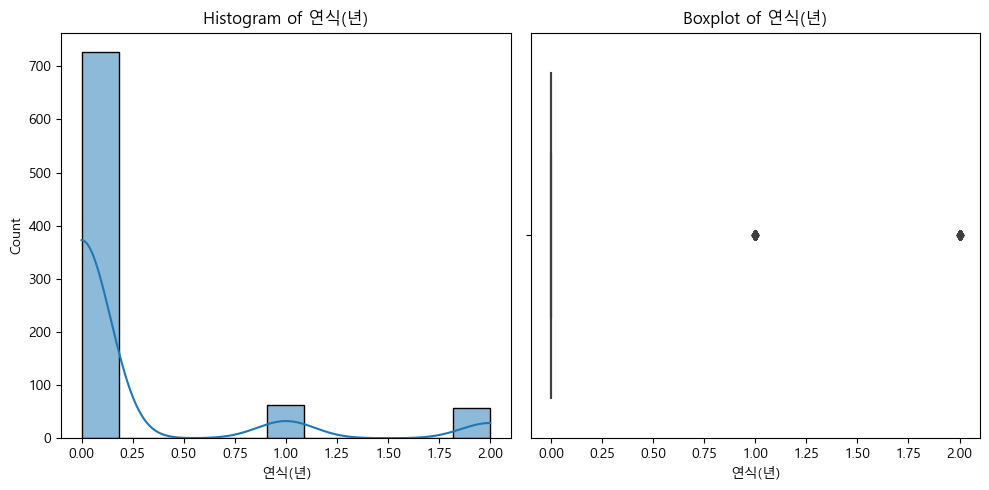

In [132]:
# test 분포 확인
plot_num(data=test, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

#### (5) 가격

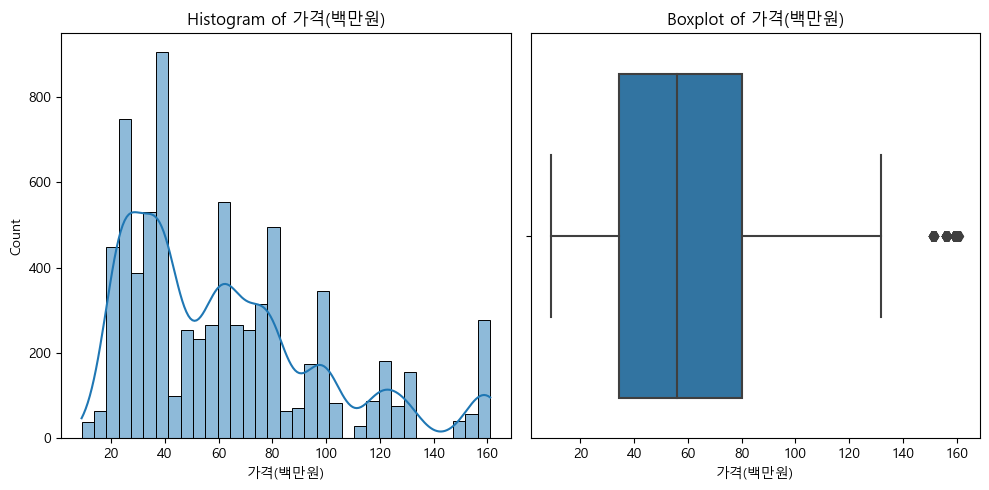

In [133]:
columns_to_plot = ['가격(백만원)']

# train 분포 확인
plot_num(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

- 종속변수가 정규형이 아님... ==> 나중에 로그화?

### 2. 범주형 변수

In [112]:
def plot_cat(data, columns_to_plot, cols=3, figsize=(10, 5)): 
    # 해당열이 데이터 내 존재하는지 확인합니다.
    valid_columns = [col for col in columns_to_plot if col in data.columns]
    if not valid_columns:
        raise ValueError("해당 열이 존재하지 않습니다.")
    
    # 서브플롯을 생성하기 위해 행과 열의 수를 확인
    num_vars = len(valid_columns)
    rows = math.ceil(num_vars / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  
    
    for i, col in enumerate(valid_columns):
        sns.countplot(x=data[col], ax=axes[i], palette="viridis", order=data[col].value_counts().index)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].tick_params(axis='x', rotation=45)
    
    # 빈 서비플롯을 삭제
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

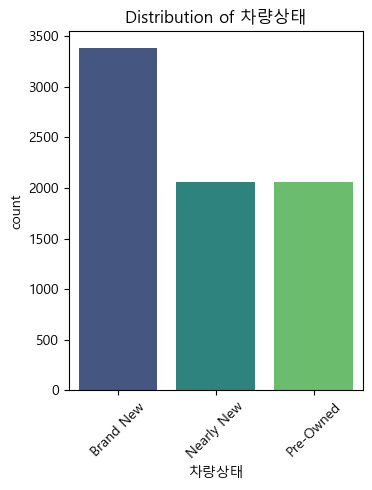

In [113]:
columns_to_plot = ['차량상태']

# train 분포 확인
plot_cat(data=train, columns_to_plot=columns_to_plot)

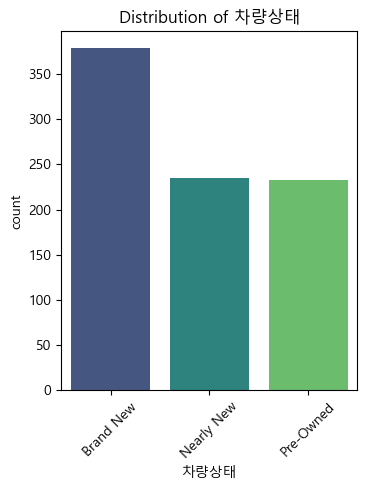

In [114]:
# test 분포 확인
plot_cat(data=test, columns_to_plot=columns_to_plot)

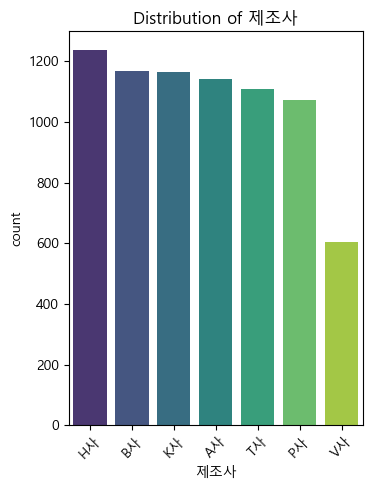

In [115]:
columns_to_plot = ['제조사']

# train 분포 확인
plot_cat(data=train, columns_to_plot=columns_to_plot)

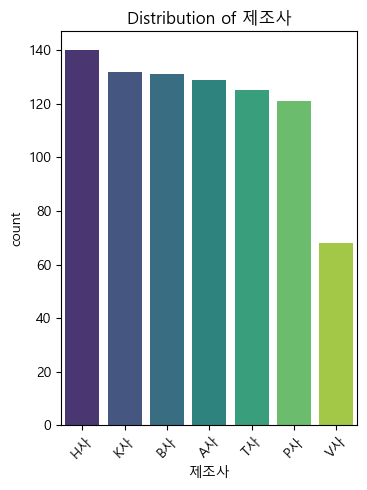

In [116]:
# test 분포 확인
plot_cat(data=test, columns_to_plot=columns_to_plot)

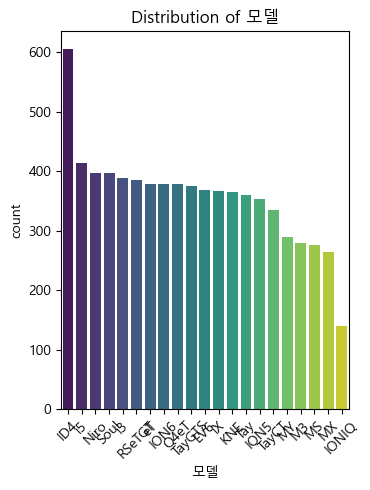

In [117]:
columns_to_plot = ['모델']

# train 분포 확인
plot_cat(data=train, columns_to_plot=columns_to_plot)

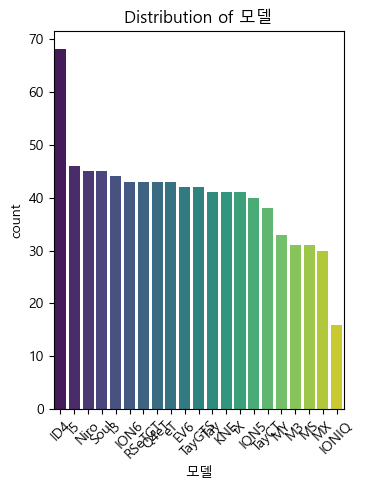

In [118]:
# test 분포 확인
plot_cat(data=test, columns_to_plot=columns_to_plot)

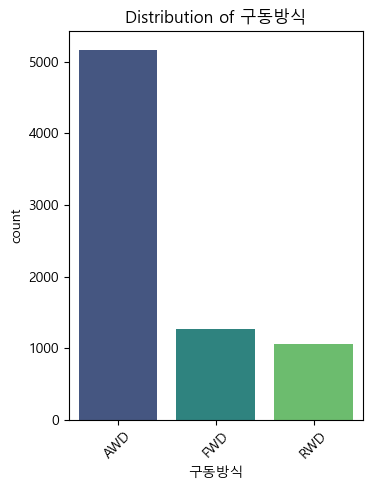

In [119]:
columns_to_plot = ['구동방식']

# train 분포 확인
plot_cat(data=train, columns_to_plot=columns_to_plot)

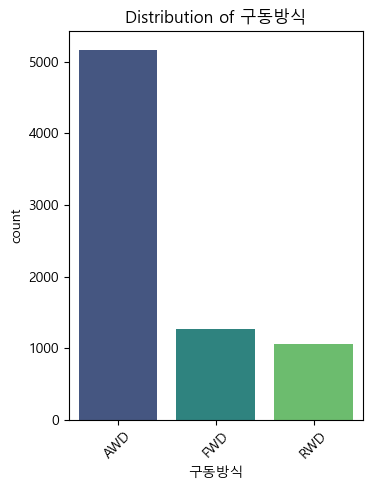

In [120]:
# test 분포 확인
plot_cat(data=train, columns_to_plot=columns_to_plot)

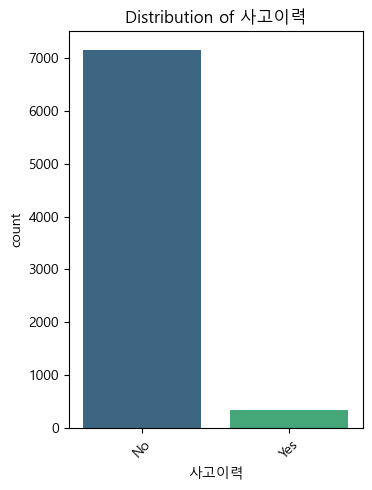

In [121]:
columns_to_plot = ['사고이력']

# train 분포 확인
plot_cat(data=train, columns_to_plot=columns_to_plot)

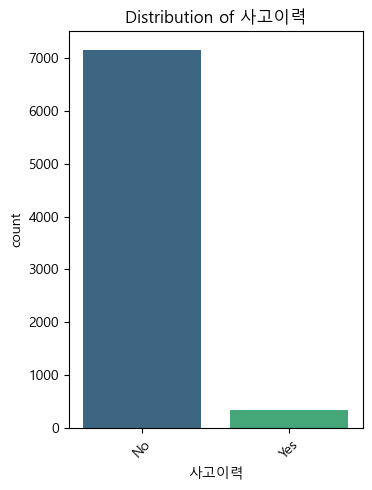

In [122]:
# test 분포 확인
plot_cat(data=train, columns_to_plot=columns_to_plot)

## 이변량 분석

### 1. 숫자 vs 숫자

In [63]:
#상관관계 확인
train.corr(numeric_only=True)

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.576538,0.558242,-0.021845,0.431668
주행거리(km),-0.576538,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.558242,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.021845,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.431668,-0.035488,-0.349962,-0.058455,1.000000


C:\ProgramData\anaconda3_2\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\ProgramData\anaconda3_2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


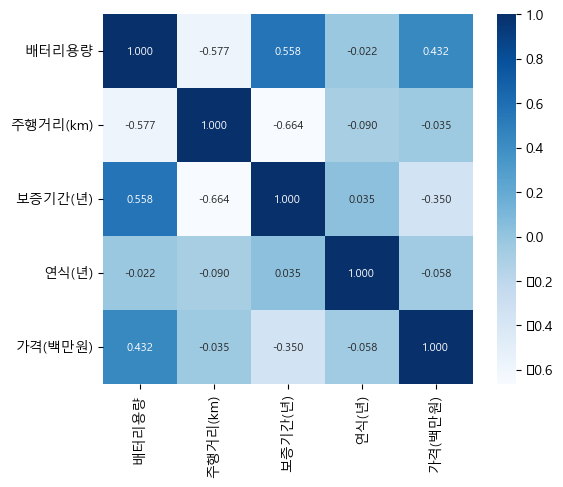

In [64]:
# 상관관계 시각화
sns.heatmap(train.corr(numeric_only=True),
    annot=True,             # 글자
    fmt = '.3f',             # 소수점
    square=True,             # 정사각형
    cmap='Blues',            # 색깔
    annot_kws={'size':8})     # 글자 크기
plt.show()

In [70]:
def eda_2_nn(data, feature, target) :
    # 산점도
    temp = data.loc[data[feature].notnull()]   #일단 NA 빼
    sns.scatterplot( x= feature, y = target, data = temp)
    plt.grid()
    plt.show()
    result = spst.pearsonr(temp[feature], temp[target])
    print(f'상관계수 : {result[0]}, P-value : {result[1]}')

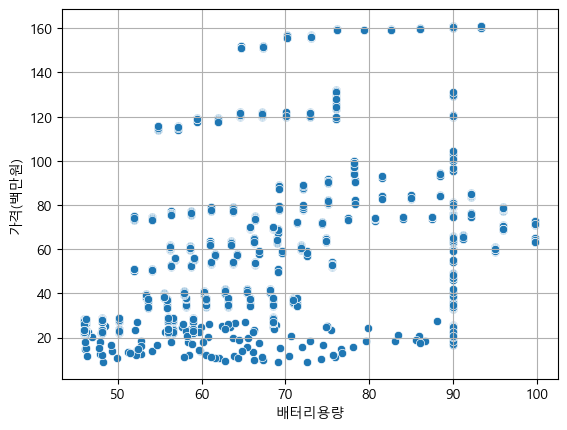

상관계수 : 0.43166811359859214, P-value : 1.6196537893489927e-216


In [71]:
eda_2_nn(train,'배터리용량','가격(백만원)')

- 배터리 용량이 90일때 다양한 값이 분포, 배터리용량이 90일 때는 가격과 크게 연관이 없는듯..!

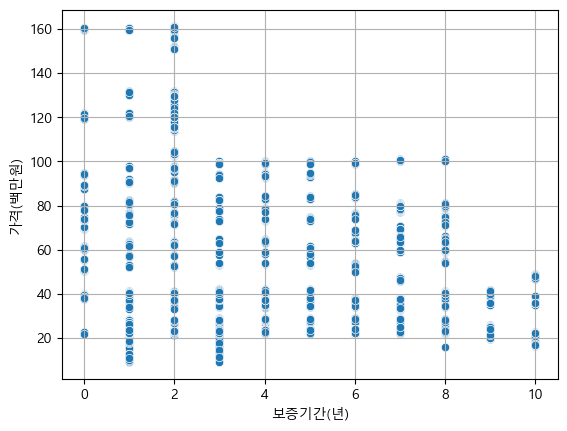

상관계수 : -0.3499615429132909, P-value : 6.146563103234424e-215


In [72]:
eda_2_nn(train,'보증기간(년)','가격(백만원)')

- 전체적으로 보증기간이 0~2사이일 떄는 다양하게 분포 ==> 가격과 큰 연관이 없어보임

### 2. 범주 vs 숫자

In [214]:
from scipy.stats import f_oneway

def analyze_vehicle_price(data, status_col, price_col):

    # Subplots for Barplot and Boxplot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Barplot
    sns.barplot(ax=axes[0], x=status_col, y=price_col, data=data)
    axes[0].set_title('Barplot of Vehicle Status vs Price')
    axes[0].grid()

    # Boxplot
    sns.boxplot(ax=axes[1], x=status_col, y=price_col, data=data)
    axes[1].set_title('Boxplot of Vehicle Status vs Price')
    axes[1].grid()

    plt.tight_layout()
    plt.show()

    # ANOVA test
    groups = [data[data[status_col] == status][price_col] for status in data[status_col].unique()]
    stat, p_value = f_oneway(*groups)

    print(f"ANOVA p-value: {p_value}")

    # 결과 해석
    if p_value < 0.05:
        print("차량 상태가 가격에 유의미한 영향을 미칩니다.")
    else:
        print("차량 상태가 가격에 유의미한 영향을 미친다고 보기 어렵습니다.")


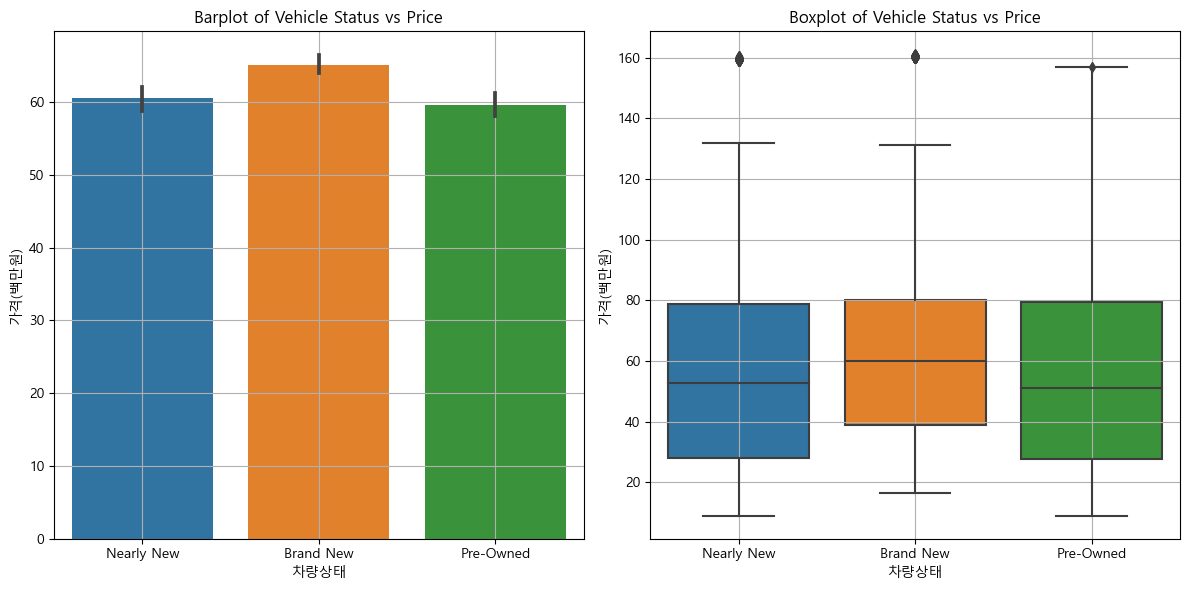

ANOVA p-value: 1.8907920861433573e-08
차량 상태가 가격에 유의미한 영향을 미칩니다.


In [227]:
analyze_vehicle_price(train, '차량상태', '가격(백만원)')

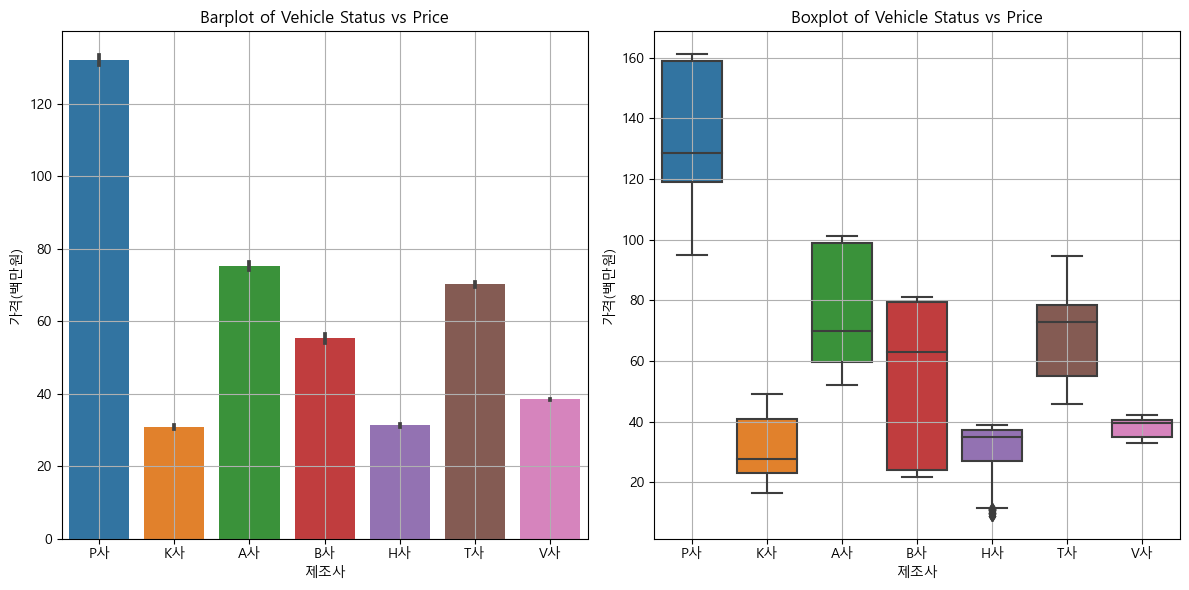

ANOVA p-value: 0.0
차량 상태가 가격에 유의미한 영향을 미칩니다.


In [228]:
analyze_vehicle_price(train, '제조사', '가격(백만원)')

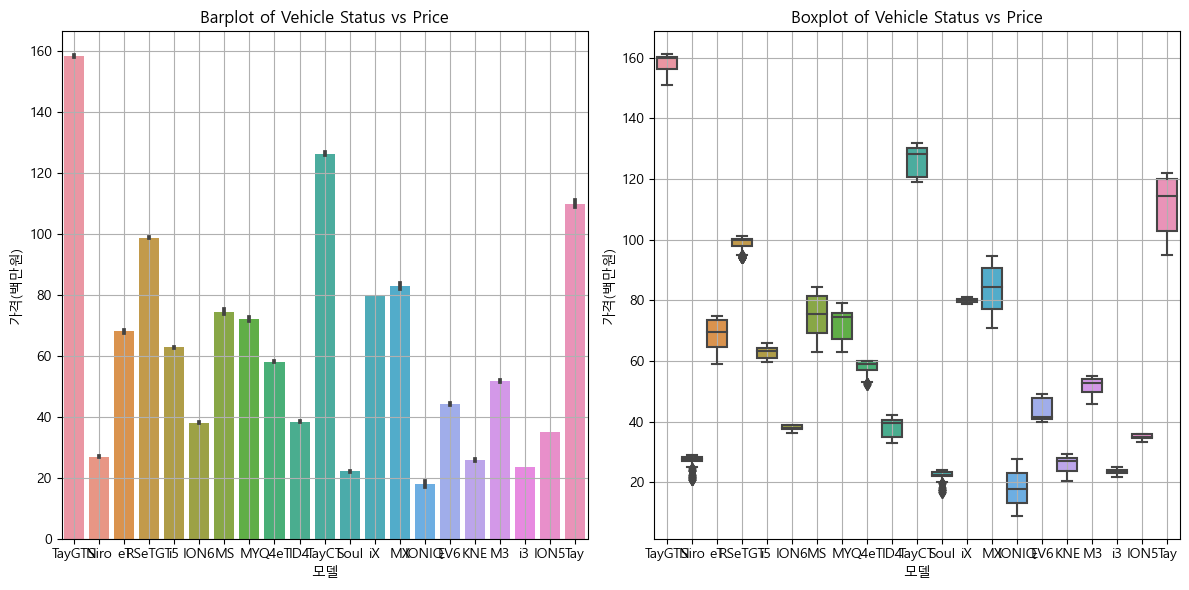

ANOVA p-value: 0.0
차량 상태가 가격에 유의미한 영향을 미칩니다.


In [229]:
analyze_vehicle_price(train, '모델', '가격(백만원)')

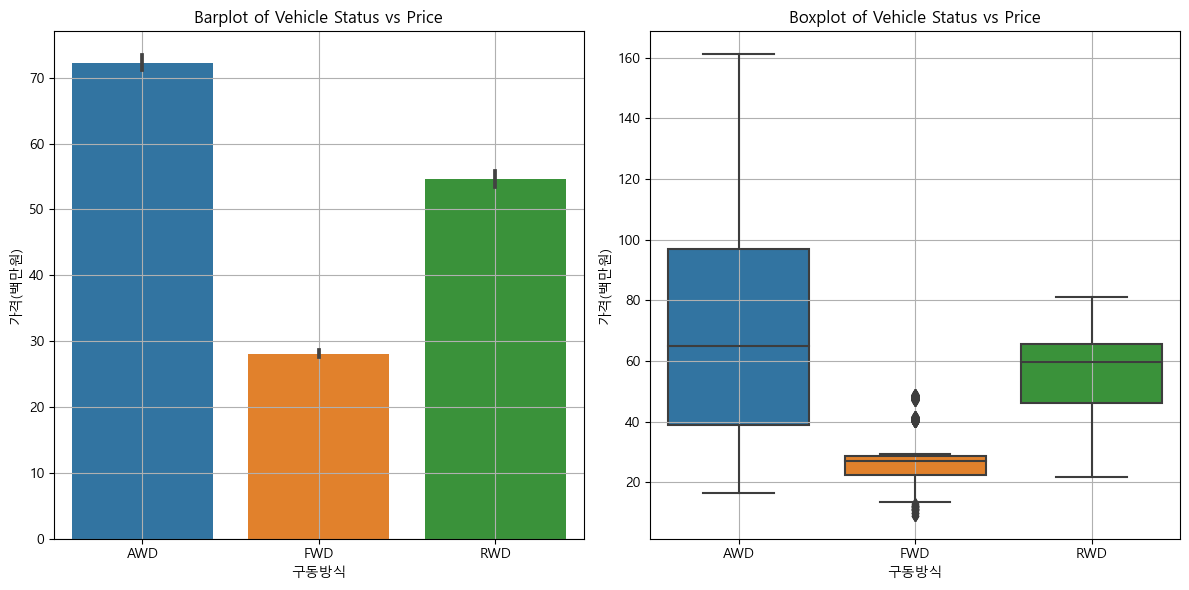

ANOVA p-value: 0.0
차량 상태가 가격에 유의미한 영향을 미칩니다.


In [230]:
analyze_vehicle_price(train, '구동방식', '가격(백만원)')

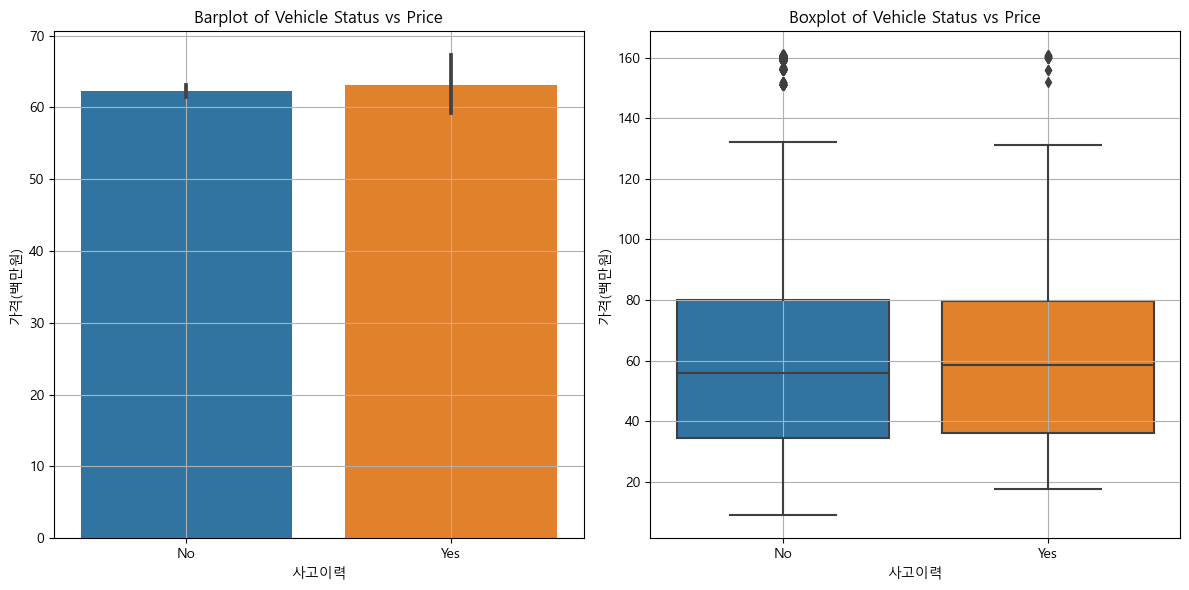

ANOVA p-value: 0.6887493806620659
차량 상태가 가격에 유의미한 영향을 미친다고 보기 어렵습니다.


In [231]:
analyze_vehicle_price(train, '사고이력', '가격(백만원)')

- 이거는 근데 애초에 사고이력의 YES 비율이 너무 적어서 그런듯?

In [89]:
def plot2(data, brand_col, model_col, price_col):
    # 제조사의 모델별 가격의 평균으로 그룹화
    grouped_data = data.groupby([brand_col, model_col])[price_col].mean().reset_index()

    # 제조사별로 정렬
    grouped_data = grouped_data.sort_values(by=[brand_col, price_col], ascending=[True, False])

    # 그래프 크기 정의
    plt.figure(figsize=(15, 8))

    # 유니크한 제조사 추출 및 색상 정의
    brands = grouped_data[brand_col].unique()
    colors = cm.tab20.colors[:len(brands)]

    # 제조사별로 모델의 가격을 바 그래프로 시각화
    for i, brand in enumerate(brands):
        brand_data = grouped_data[grouped_data[brand_col] == brand]
        plt.bar(
            brand_data[model_col],
            brand_data[price_col],
            label=brand,
            color=colors[i % len(colors)]
        )

    # 그래프 설정
    plt.title(f'{brand_col} 별 {model_col} {price_col} 분포', fontsize=16)
    plt.xlabel(model_col, fontsize=12)
    plt.ylabel(price_col, fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.legend(title=brand_col, fontsize=10, loc='upper right')
    plt.tight_layout()
    plt.show()


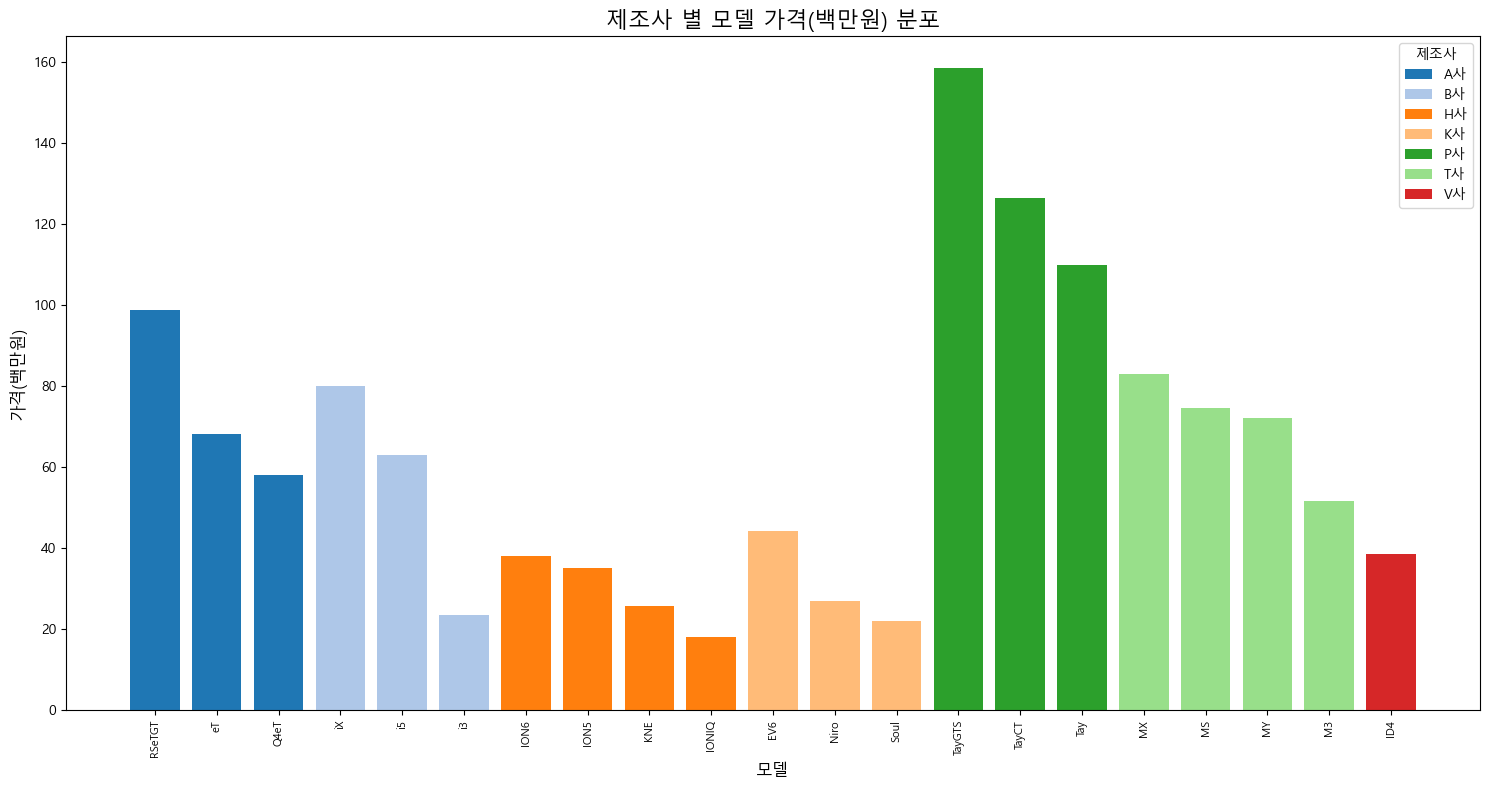

In [90]:
plot2(train, '제조사', '모델', '가격(백만원)')

- P사 가격이 상대적으로 높고 대부분 초중저 가격이 다 존재함

## 데이터 전처리

### 1. 결측치 처리

In [135]:
display(train.isnull().sum())
display(test.isnull().sum())

ID             0
제조사            0
모델             0
차량상태           0
배터리용량       2711
구동방식           0
주행거리(km)       0
보증기간(년)        0
사고이력           0
연식(년)          0
가격(백만원)        0
dtype: int64

ID            0
제조사           0
모델            0
차량상태          0
배터리용량       304
구동방식          0
주행거리(km)      0
보증기간(년)       0
사고이력          0
연식(년)         0
dtype: int64

In [272]:
# 제조사별+모델별 평균으로 대체
grouped_battery = train.groupby(['제조사', '모델'])['배터리용량'].transform('mean')
grouped_battery2 = test.groupby(['제조사', '모델'])['배터리용량'].transform('mean')
train['배터리용량'].fillna(grouped_battery,inplace=True)
test['배터리용량'].fillna(grouped_battery2,inplace=True)

In [273]:
# 학습과 예측을 위해 데이터를 분리
x_train = train.drop(['ID', '가격(백만원)'], axis = 1)
y_train = train['가격(백만원)']

x_test = test.drop('ID', axis = 1)

In [274]:
# Minmax
numeric_cols = x_train.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()

x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

In [275]:
# 범주형 변수에 대해 레이블 인코딩을 적용합니다.
categorical_features = [col for col in x_train.columns if x_train[col].dtype == 'object']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(x_train[i]) 
    x_train[i]=le.transform(x_train[i])
    
    for case in np.unique(x_test[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    x_test[i]=le.transform(x_test[i])
    
display(x_train.head(3))

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,4,16,1,0.744926,0,0.068255,0.0,0,1.0
1,3,10,1,0.185874,1,0.051025,0.6,0,0.0
2,0,17,0,0.840149,0,0.011800,0.7,0,0.0


## 모델링

### 1. Decision Tree

In [139]:
# 모델을 선언하고, 학습을 진행합니다.
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

DecisionTreeRegressor()

In [147]:
# 예측을 수행합니다.
pred = model.predict(x_test)

### 2. Decision Tree + GridSearch

In [277]:
# 선언하기
model_dt = DecisionTreeRegressor()

# 성능예측
cv_score = cross_val_score(model_dt, x_train, y_train, cv=10)

# 결과확인
print(cv_score)
print(cv_score.mean())

[0.99694188 0.99745559 0.99787464 0.99659813 0.99784607 0.99726405
 0.9976929  0.99692202 0.99856953 0.99727583]
0.9974440640744525


In [278]:
# 선언하기
model_dt = DecisionTreeRegressor()

# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1, 51)}

# Random Search 선언
# cv = 5
# n_iter = 20
# scoring = 'r2'
model8 = GridSearchCV(model_dt,        # 튜닝할 기본 모델
                       param,          # 테스트 대상 매개변수 범위
                       cv = 5,         # K-Fold cv 개수
                       scoring = 'r2')  # 평가 지표(회귀의 기본), r2 언급 안해줘도 됨

In [279]:
model8.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 51)}, scoring='r2')

In [280]:
# 중요 정보 확인
print('=' * 80)
print('테스트로 얻은 성능')
print(model2.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model8.best_params_)
print('-' * 80)
print('최고성능:', model8.best_score_)
print('=' * 80)

테스트로 얻은 성능
[0.25839788 0.72164427 0.90541594 0.95797773 0.98492346 0.99449936
 0.99662707 0.99799112 0.99816328 0.99821789 0.99794397 0.99793337
 0.99779992 0.99777142 0.99762712 0.99767243 0.99762554 0.99750132
 0.99756876 0.9975617  0.99758958 0.99750361 0.99740355 0.99747534
 0.99738045 0.99743766 0.99740012 0.99735717 0.99743584 0.9974549
 0.99738035 0.99732519 0.99734248 0.99744518 0.99735332 0.99746463
 0.99737264 0.99734851 0.99743011 0.99743832 0.99728444 0.99740101
 0.99740831 0.99729924 0.99736705 0.99739851 0.99742446 0.997319
 0.99731258 0.99737287]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 9}
--------------------------------------------------------------------------------
최고성능: 0.9981484636872846


In [281]:
pred8 = model8.predict(x_test)

### 3. RandomForest

In [199]:
# 선언하기
model_rf = RandomForestRegressor()

# 파라미터 선언
# max_depth: 1~50
param = {
    'max_depth': range(1, 51),                  # 최대 깊이
    #'n_estimators': [50, 100, 200, 300, 500],  # 트리 개수
    #'min_samples_split': [2, 5, 10, 20],       # 노드 분할 최소 샘플 수
    #'min_samples_leaf': [1, 2, 4, 10],         # 리프 노드 최소 샘플 수
    #'max_features': ['auto', 'sqrt', 'log2'],  # 분할 시 고려할 최대 피처
    #'bootstrap': [True, False],                # 부트스트랩 사용 여부
}

# Random Search 선언
# cv = 5
# n_iter = 20
# scoring = 'r2'
model3 = GridSearchCV(model_rf,        # 튜닝할 기본 모델
                       param,          # 테스트 대상 매개변수 범위
                       cv = 5,         # K-Fold cv 개수
                       scoring = 'r2')  # 평가 지표(회귀의 기본), r2 언급 안해줘도 됨

In [200]:
model3.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 51)}, scoring='r2')

In [201]:
# 중요 정보 확인
print('=' * 80)
print('테스트로 얻은 성능')
print(model2.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model2.best_params_)
print('-' * 80)
print('최고성능:', model2.best_score_)
print('=' * 80)

테스트로 얻은 성능
[0.25839788 0.72164427 0.90541594 0.95797773 0.98492346 0.99449936
 0.99662707 0.99799112 0.99816328 0.99821789 0.99794397 0.99793337
 0.99779992 0.99777142 0.99762712 0.99767243 0.99762554 0.99750132
 0.99756876 0.9975617  0.99758958 0.99750361 0.99740355 0.99747534
 0.99738045 0.99743766 0.99740012 0.99735717 0.99743584 0.9974549
 0.99738035 0.99732519 0.99734248 0.99744518 0.99735332 0.99746463
 0.99737264 0.99734851 0.99743011 0.99743832 0.99728444 0.99740101
 0.99740831 0.99729924 0.99736705 0.99739851 0.99742446 0.997319
 0.99731258 0.99737287]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 10}
--------------------------------------------------------------------------------
최고성능: 0.9982178862250877


In [202]:
pred3 = model3.predict(x_test)

In [203]:
submit = pd.read_csv('sample_submission.csv')
# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred3
submit.head()
submit.to_csv('submission3.csv',index=False)

### 4. xgb

In [182]:
# 선언하기
model4 = XGBRegressor(max_depth=5, n_estimators=100)
# 학습하기
model4.fit(x_train, y_train)
# 예측하기
pred4 = model4.predict(x_test)

In [183]:
submit = pd.read_csv('sample_submission.csv')
# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred4
submit.head()
submit.to_csv('submission4.csv',index=False)

In [150]:
submit = pd.read_csv('sample_submission.csv')

In [152]:
# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred
submit.head()

,ID,가격(백만원)
0,TEST_000,130.84
1,TEST_001,79.26
2,TEST_002,64.70
3,TEST_003,35.00
4,TEST_004,47.16


In [153]:
submit.to_csv('submission.csv',index=False)

### 5. 제조사+모델별+구동방식+차량상태 결측치 처리

In [ ]:
# 배터리용량과 관련된 변수들 파악
#주행거리+보증기간


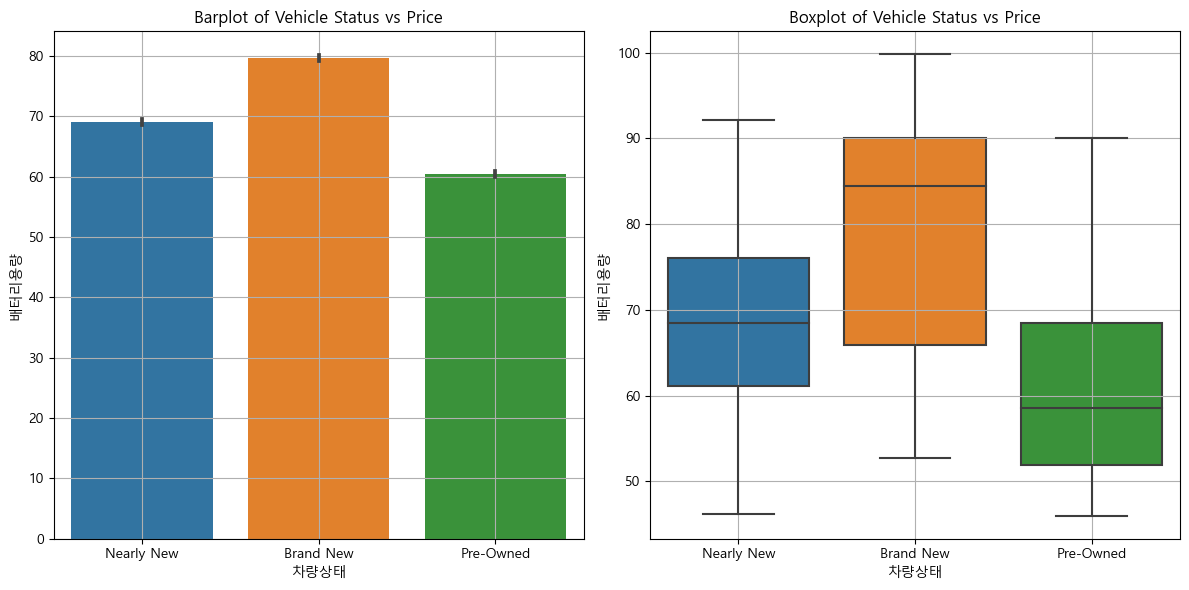

ANOVA p-value: 0.0
차량 상태가 가격에 유의미한 영향을 미칩니다.


In [221]:
analyze_vehicle_price(train, '차량상태', '배터리용량')

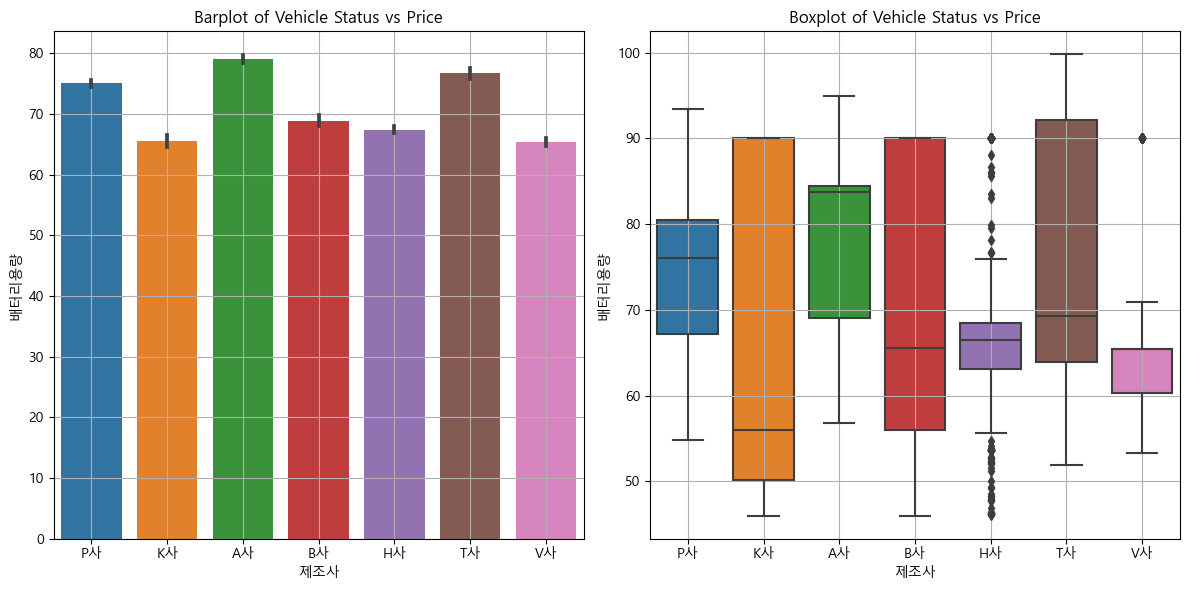

ANOVA p-value: 1.5978112671642347e-223
차량 상태가 가격에 유의미한 영향을 미칩니다.


In [222]:
analyze_vehicle_price(train, '제조사', '배터리용량')

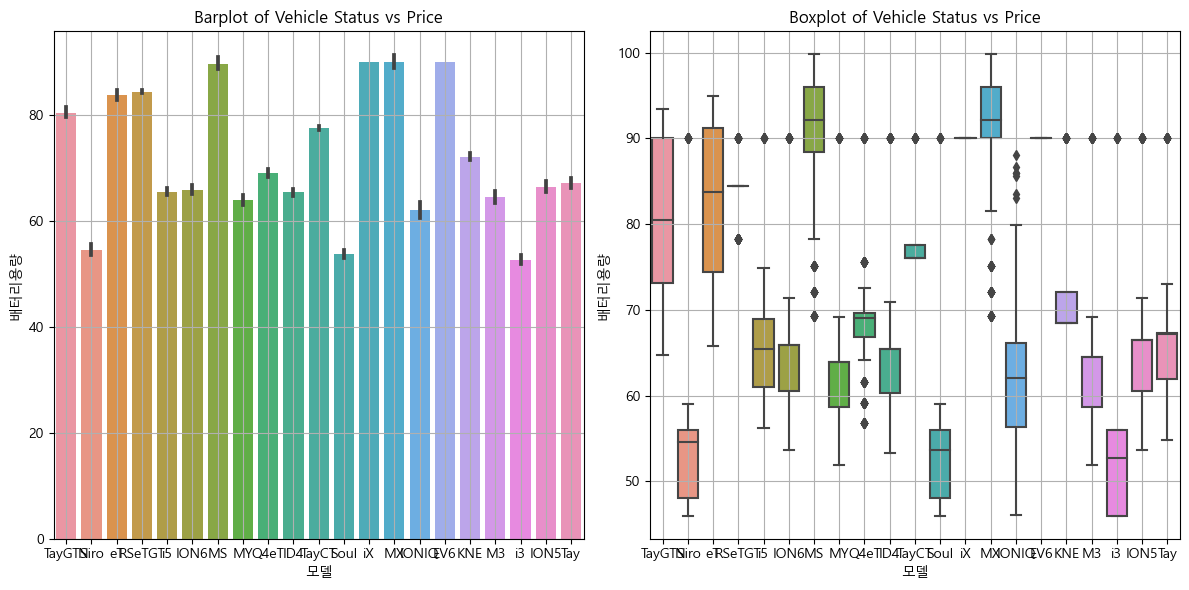

ANOVA p-value: 0.0
차량 상태가 가격에 유의미한 영향을 미칩니다.


In [223]:
analyze_vehicle_price(train, '모델', '배터리용량')

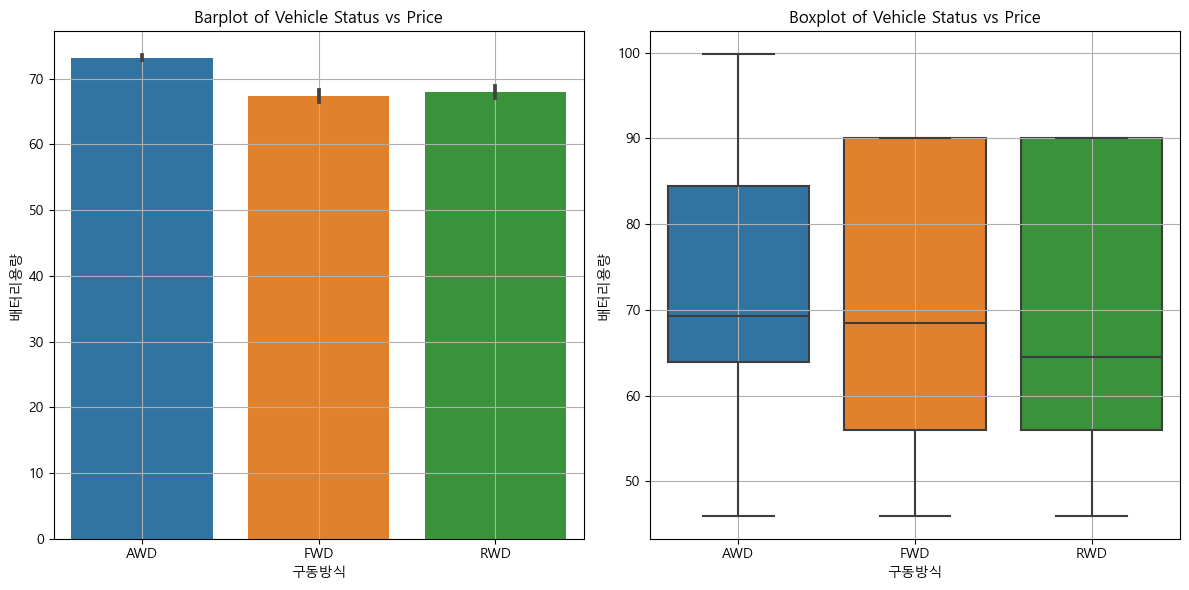

ANOVA p-value: 3.1163471048536794e-53
차량 상태가 가격에 유의미한 영향을 미칩니다.


In [224]:
analyze_vehicle_price(train, '구동방식', '배터리용량')

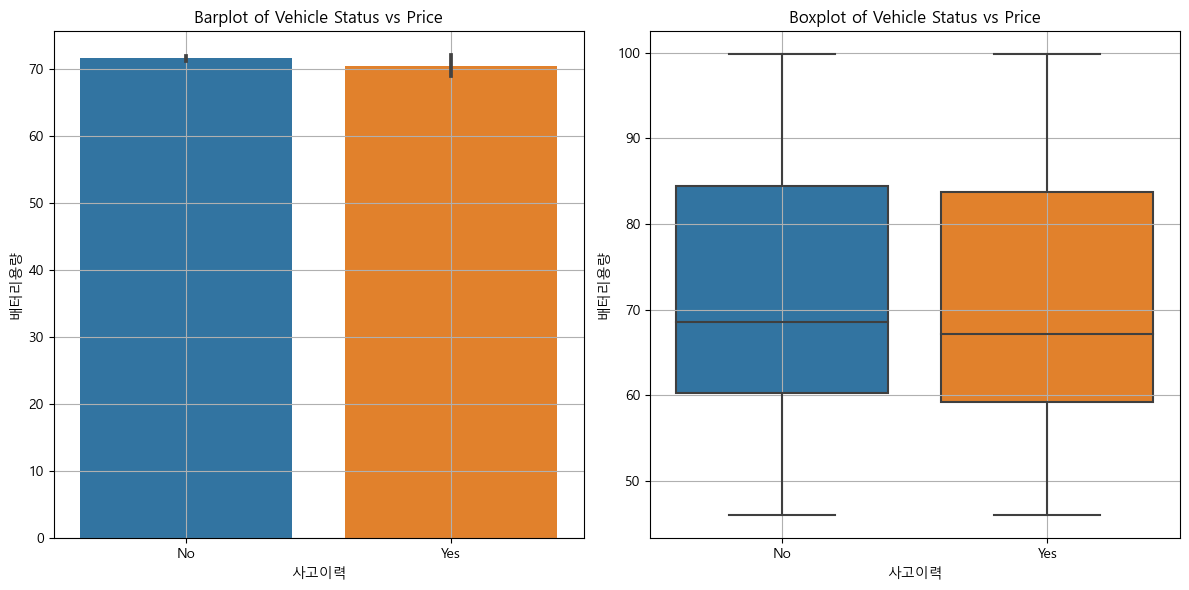

ANOVA p-value: 0.1645582771185493
차량 상태가 가격에 유의미한 영향을 미친다고 보기 어렵습니다.


In [225]:
analyze_vehicle_price(train, '사고이력', '배터리용량')

In [249]:
# 제조사별+모델별 평균으로 대체
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train2 = train.copy()
test2 = test.copy()
grouped_battery3 = train2.groupby(['제조사', '모델', '차량상태' , '구동방식'])['배터리용량'].transform('mean')
grouped_battery4 = test2.groupby(['제조사', '모델'])['배터리용량'].transform('mean')
train2['배터리용량'].fillna(grouped_battery3,inplace=True)
test2['배터리용량'].fillna(grouped_battery4,inplace=True)

In [250]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train2 = train2.drop(['ID', '가격(백만원)'], axis = 1)
y_train2 = train2['가격(백만원)']

x_test2 = test2.drop('ID', axis = 1)

In [251]:
# 범주형 변수에 대해 레이블 인코딩을 적용합니다.
categorical_features = [col for col in x_train2.columns if x_train2[col].dtype == 'object']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(x_train2[i]) 
    x_train2[i]=le.transform(x_train2[i])
    
    for case in np.unique(x_test2[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    x_test2[i]=le.transform(x_test2[i])
    
display(x_train2.head(3))

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,4,16,1,86.077,0,13642,0,0,2
1,3,10,1,56.000,1,10199,6,0,0
2,0,17,0,91.200,0,2361,7,0,0


In [252]:
# 선언하기
model_dt = DecisionTreeRegressor()

# 성능예측
cv_score = cross_val_score(model_dt, x_train2, y_train2, cv=10)

# 결과확인
print(cv_score)
print(cv_score.mean())

[0.99707721 0.99799386 0.99806213 0.9961144  0.99762879 0.99779917
 0.99752268 0.99668937 0.99892741 0.99730252]
0.9975117544603591


In [253]:
# 선언하기
model_dt = DecisionTreeRegressor()

# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1, 51)}

# Random Search 선언
# cv = 5
# n_iter = 20
# scoring = 'r2'
model7 = GridSearchCV(model_dt,        # 튜닝할 기본 모델
                       param,          # 테스트 대상 매개변수 범위
                       cv = 5,         # K-Fold cv 개수
                       scoring = 'r2')  # 평가 지표(회귀의 기본), r2 언급 안해줘도 됨

In [254]:
model7.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 51)}, scoring='r2')

In [255]:
pred7 = model7.predict(x_test)
submit = pd.read_csv('sample_submission.csv')
# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred7
submit.head()
submit.to_csv('submission7.csv',index=False)

In [284]:
pred8 = model8.predict(x_test)
submit = pd.read_csv('sample_submission.csv')
# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred8
submit.head()
submit.to_csv('submission8.csv',index=False)

### 6. lgbm

In [286]:
# 선언하기
model9 = LGBMRegressor(max_depth=5, n_estimators=100)
# 학습하기
model9.fit(x_train, y_train)
# 예측하기
pred9 = model9.predict(x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [287]:
pred9 = model9.predict(x_test)
submit = pd.read_csv('sample_submission.csv')
# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred9
submit.head()
submit.to_csv('submission9.csv',index=False)

## 결과

- 제조사별+모델별 평균 결측치 처리 + decisiontree base: 75->1.51692
- 제조사별+모델별 평균 결측치 처리 + decisiontree 그리드서치: 1.06318
- 제조사별+모델별 평균 결측치 처리 + xgb: 1.23
- 제조사별+모델별 평균 결측치 처리+randomforest+gridsearch: 0.99974
- 제조사별+모델별+차량상태별+구동방식별+dt+gridsearch: 1.0631894334
- 제조사별+모델별+lgbm: 1.1966252115

======scaling 포함====
- decisiontree gridserch + minmaxscaler: 1.083